In [0]:
import geopandas
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection
from sklearn import kernel_ridge
from sklearn import svm
from sklearn import tree
from sklearn import dummy
from sklearn import covariance
from sklearn import feature_selection
from sklearn import ensemble
from scipy import stats
import matplotlib.pyplot as plt
import pickle

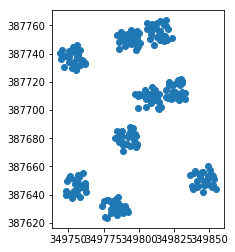

In [413]:
fw_pts = geopandas.read_file('/Volumes/Gibbs_Drive/Data_Master/Points_S2_VI_S1_BP_S2RAT_S1RAT.shp')
points = fw_pts
X = points.loc[:, X_col_names]
print(' ')
points.plot()

In [0]:
#Names of the independent variables that will be predicted:
y_col_names = ['Dry_wgh', 'Frsh_wg', 'FDN', 'FDA', 'CP', 'DIVMS']
y_col_full_names = ['Dry Weight Biomass', 'Fresh Weight Biomass', 'Neutral Detergent Fiber', 'Acid Detergent Fiber', 'Crude Protein', 'In-Vitro Dry Matter Digestibility']

#Names of the predictor variables
X_col_names = list(points)[23:(len(list(points))-1)]

In [0]:
def evaluate_model(reg, X_scaled, y_scaled):
  #previously used: neg_median_absolute_error, neg_mean_squared_error
  mse_scores = model_selection.cross_validate(reg, X_scaled, y_scaled, scoring='neg_median_absolute_error', cv=5)
  mse_scores = mse_scores['test_score']
  
  X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=0)
  reg.fit(X_train, y_train)
  pred = reg.predict(X_test)
  r2 = metrics.r2_score(y_test, pred)
  return(mse_scores.mean(), r2)


In [0]:
#Give baseline prediction using MLR
mlr_data = []

#Scale X data
X_scaled = points.loc[:, X_col_names]


for col in list(X_scaled):
  X_scaled.loc[:, col] = preprocessing.scale(np.array(X_scaled.loc[:, col]))
X_scaled = X_scaled.to_numpy()

for var in y_col_names:
  y = np.array(points.loc[:, var])
  y_scaled = preprocessing.scale(y)
  y_scaled = np.ravel(y_scaled)
  y_scaled.shape
  
  reg = linear_model.LinearRegression()
  eval_result = evaluate_model(reg, X_scaled, y_scaled)
  mlr_data.append((var, type(reg).__name__, eval_result[0], eval_result[1]))
  
mlr_df = pd.DataFrame.from_dict(mlr_data, orient='columns', dtype=None, columns=None)
mlr_df.columns = ['variable', 'model_name', 'cv_mae', 'r2']
mlr_df.to_csv('/Volumes/Gibbs_Drive/Results/Non_Optimized_MLR_Performance.csv')

In [0]:
regression_models = [linear_model.LinearRegression(), 
                     linear_model.Ridge(alpha=.5),
                     linear_model.Lasso(alpha=0.1),
                     linear_model.BayesianRidge(),
                     kernel_ridge.KernelRidge(),
                     svm.LinearSVR(max_iter=5000),
                     tree.DecisionTreeRegressor(),
                     ensemble.RandomForestRegressor(n_estimators=10),
                     tree.ExtraTreeRegressor()]

In [420]:
model_data = []

#Scale X data
X_scaled = points.loc[:, X_col_names]


for col in list(X_scaled):
  X_scaled.loc[:, col] = preprocessing.scale(np.array(X_scaled.loc[:, col]))
X_scaled = X_scaled.to_numpy()

#For each dependent variable, create new dataset, scale y data
for var in y_col_names:
  y = np.array(points.loc[:, var])
  y_scaled = preprocessing.scale(y)
  y_scaled = np.ravel(y_scaled)
  y_scaled.shape
  
  #for each regression model, test against the dependent variable
  for reg in regression_models:
    eval_result = evaluate_model(reg, X_scaled, y_scaled)
    model_data.append((var, type(reg).__name__, eval_result[0], eval_result[1]))


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
model_compare_df = pd.DataFrame.from_dict(model_data, orient='columns', dtype=None, columns=None)
model_compare_df.columns = ['variable', 'model_name', 'cv_mae', 'r2']
model_compare_df.to_csv('/Volumes/Gibbs_Drive/Results/Model_Comparison_2.csv')

In [422]:
model_compare_df.head()

,variable,model_name,cv_mae,r2
0,Dry_wgh,LinearRegression,-23.383864,-8.913612
1,Dry_wgh,Ridge,-0.926486,0.659163
2,Dry_wgh,Lasso,-0.822048,0.451008
3,Dry_wgh,BayesianRidge,-0.714324,0.592235
4,Dry_wgh,KernelRidge,-0.486827,0.669656


In [0]:
max_mse = pd.DataFrame([])
max_r2 = pd.DataFrame([])

for var in y_col_names:
  max_mse = max_mse.append(model_compare_df.loc[model_compare_df.loc[model_compare_df['variable'] == var, :]['cv_mae'].idxmax(), :])
  
  max_r2 = max_r2.append(model_compare_df.loc[model_compare_df.loc[model_compare_df['variable'] == var, :]['r2'].idxmax(), :])
  
  #find the best model for each variable based on mse and r2 (may not be the same - favor mse)
max_mse.to_csv('/Volumes/Gibbs_Drive/Results/Non_Optimized_MAE_Performance.csv')
max_r2.to_csv('/Volumes/Gibbs_Drive/Results/Non_Optimized_R2_Performance.csv')

In [425]:
max_mse

,cv_mae,model_name,r2,variable
4,-0.486827,KernelRidge,0.669656,Dry_wgh
13,-0.649007,KernelRidge,0.518494,Frsh_wg
25,-0.813400,RandomForestRegressor,0.561580,FDN
30,-0.716450,BayesianRidge,0.061550,FDA
40,-0.583779,KernelRidge,0.403573,CP
47,-0.668364,Lasso,0.131021,DIVMS


In [426]:
#Sample size is so small that it is affecting cross val, generalization error is overestimated (sklean docs)
#this is a tradeoff as random forest has some random performance

max_r2

,cv_mae,model_name,r2,variable
4,-0.486827,KernelRidge,0.669656,Dry_wgh
13,-0.649007,KernelRidge,0.518494,Frsh_wg
25,-0.813400,RandomForestRegressor,0.561580,FDN
34,-0.751508,RandomForestRegressor,0.532126,FDA
43,-0.712716,RandomForestRegressor,0.706638,CP
52,-0.805849,RandomForestRegressor,0.475427,DIVMS


In [0]:
#using different approach to optimize feature set
#Rank independent variables by importance for each dependent variable (for RF)
feature_importance = []

#Scale X data
X_scaled = points.loc[:, X_col_names]


for col in list(X_scaled):
  X_scaled.loc[:, col] = preprocessing.scale(np.array(X_scaled.loc[:, col]))
X_scaled = X_scaled.to_numpy()

#For each dependent variable, create new dataset, scale y data
for var in y_col_names:
  y = np.array(points.loc[:, var])
  y_scaled = preprocessing.scale(y)
  y_scaled = np.ravel(y_scaled)
  y_scaled.shape

  reg = ensemble.RandomForestRegressor(n_estimators=10)
  X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=0)
  reg.fit(X_train, y_train)
  feature_importance = feature_importance + list(zip([var] * len(X_col_names), X_col_names, reg.feature_importances_))

feature_importance_df = pd.DataFrame(feature_importance)
feature_importance_df.columns = ['variable', 'feature_name', 'importance']


In [428]:
feature_importance_df.head()

,variable,feature_name,importance
0,Dry_wgh,B2,0.000386
1,Dry_wgh,B3,0.000841
2,Dry_wgh,B4,0.000847
3,Dry_wgh,B5,0.001932
4,Dry_wgh,B6,0.002714


In [0]:
#only select features above mean importance of all features

most_important = pd.DataFrame([])

for var in y_col_names:
  
  group_mean = feature_importance_df.loc[feature_importance_df['variable'] == var, 'importance'].mean()

  most_important = most_important.append(feature_importance_df.loc[(feature_importance_df['variable'] == var) & (feature_importance_df['importance'] >= group_mean), :].sort_values(by='importance', ascending=False))
most_important.to_csv('/Volumes/Gibbs_Drive/Results/Optimized_Variable_Names_RF.csv')

In [0]:
model_data_opt = []

#repeat regression with different model but these selected variables
reg_var_pairs = [(kernel_ridge.KernelRidge(), 'Dry_wgh'),
                 (kernel_ridge.KernelRidge(), 'Frsh_wg'),
                 (ensemble.RandomForestRegressor(n_estimators=10), 'FDN'),
                 (ensemble.RandomForestRegressor(n_estimators=10), 'FDA'),
                 (ensemble.RandomForestRegressor(n_estimators=10), 'CP'),
                 (ensemble.RandomForestRegressor(n_estimators=10), 'DIVMS')]

#check regression performance with optimized feature set here

for pair in reg_var_pairs:
  reg = pair[0]
  var = pair[1]
  
  X_col_names_opt = list(most_important.loc[most_important['variable'] == var, 'feature_name'])
  
  X_scaled = points.loc[:, X_col_names_opt]

  for col in list(X_scaled):
    X_scaled.loc[:, col] = preprocessing.scale(np.array(X_scaled.loc[:, col]))
  X_scaled = X_scaled.to_numpy()

  y = np.array(points.loc[:, var])
  y_scaled = preprocessing.scale(y)
  y_scaled = np.ravel(y_scaled)
  y_scaled.shape
  
  eval_result = evaluate_model(reg, X_scaled, y_scaled)
  model_data_opt.append((var, type(reg).__name__, eval_result[0], eval_result[1]))

#dataframe of regression performance using best performing r2 models from above and selected feature set from random forest feature selection (a different approach than previous)
model_compare_opt_df = pd.DataFrame.from_dict(model_data_opt, orient='columns', dtype=None, columns=None)
model_compare_opt_df.columns = ['variable', 'model_name', 'cv_mae', 'r2']
model_compare_opt_df.to_csv('/Volumes/Gibbs_Drive/Results/Optimized_Performance_RF.csv')

#improved some model R2, didnt effect others

In [431]:
#now, for each variable - make new y
#scale X
#for each number of possible variables, see which number produces best r2 result

var_nums = []
variables =[]
prediction_results = []

for var in y_col_names:
  print(var)
  y = np.array(points.loc[:, var])
  y = preprocessing.scale(y)
  y = np.ravel(y)

  data_list = []

  feature_nums = range(1, 129)

  #Scale Data
  X_scaled = X

  for col in list(X_scaled):
    X_scaled.loc[:, col] = preprocessing.scale(np.array(X_scaled.loc[:, col]))
  X_scaled = X_scaled.to_numpy()
  
  for num in feature_nums:
    X_new = feature_selection.SelectKBest(feature_selection.f_regression, k=num).fit_transform(X_scaled, y)
    X_scaled = X_new
  
    reg = ensemble.RandomForestRegressor(n_estimators=10)
    eval_result = evaluate_model(reg, X_scaled, y_scaled)
    r2 = eval_result[1]
     
    data_list.append((num, r2))
    
    X_scaled = X
    for col in list(X_scaled):
      X_scaled.loc[:, col] = preprocessing.scale(np.array(X_scaled.loc[:, col]))
    X_scaled = X_scaled.to_numpy()
    
  metric_df = pd.DataFrame.from_dict(data_list, orient='columns', dtype=None, columns=None)
  metric_df.columns = ['var_num', 'r2']
  
  #get index of maximum r2 value
  r2_max = metric_df['r2'].idxmax()

  var_nums.append(r2_max)
  
  selector = feature_selection.SelectKBest(feature_selection.f_regression, k=(r2_max + 1))
  X_new = selector.fit_transform(X_scaled, y)
  X_scaled = X_new
  
  cols = selector.get_support(indices=True)
  X_col_new = X.iloc[:, cols]
  variables.append(list(X_col_new))

  reg = ensemble.RandomForestRegressor(n_estimators=10)
  eval_result = evaluate_model(reg, X_scaled, y_scaled)
  mae = eval_result[0]
  r2 = eval_result[1]
  
  prediction_results.append((var, mae, r2))
#opt_prediction_df = pd.DataFrame.from_dict(prediction_results, orient='columns', dtype=None, columns=None)
#opt_prediction_df.columns = ['var_name', 'cv_mae', 'r2']
#opt_prediction_df.to_csv('/Volumes/Gibbs_Drive/Results/RF_Optimized_Prediction_Results.csv')

variables_df = pd.DataFrame.from_records(variables)
variables_df = variables_df.transpose()
variables_df.columns = y_col_names
variables_df.to_csv('/Volumes/Gibbs_Drive/Results/Optimized_Variable_Names_KBest.csv')

Dry_wgh
Frsh_wg
FDN
FDA
CP
DIVMS


In [0]:
optimize_names = pd.read_csv('/Volumes/Gibbs_Drive/Results/Optimized_Variable_Names_KBest.csv').iloc[:, 1:]

In [0]:
model_data_opt_3 = []

#repeat regression with different model but these selected variables
reg_var_pairs = [(kernel_ridge.KernelRidge(), 'Dry_wgh'),
                 (kernel_ridge.KernelRidge(), 'Frsh_wg'),
                 (ensemble.RandomForestRegressor(n_estimators=10), 'FDN'),
                 (ensemble.RandomForestRegressor(n_estimators=10), 'FDA'),
                 (ensemble.RandomForestRegressor(n_estimators=10), 'CP'),
                 (ensemble.RandomForestRegressor(n_estimators=10), 'DIVMS')]

for pair in reg_var_pairs:
  reg = pair[0]
  var = pair[1]
  
  X_col_names_opt = list(optimize_names.loc[optimize_names[var].notna(), var])
  
  X_scaled = points.loc[:, X_col_names_opt]
  
  for col in list(X_scaled):
    X_scaled.loc[:, col] = preprocessing.scale(np.array(X_scaled.loc[:, col]))
  X_scaled = X_scaled.to_numpy()

  y = np.array(points.loc[:, var])
  y_scaled = preprocessing.scale(y)
  y_scaled = np.ravel(y_scaled)
  y_scaled.shape
  
  eval_result = evaluate_model(reg, X_scaled, y_scaled)
  model_data_opt_3.append((var, type(reg).__name__, eval_result[0], eval_result[1]))

#dataframe of regression performance using best performing r2 models from above and selected feature set from random forest feature selection (a different approach than previous)
model_compare_opt_3_df = pd.DataFrame.from_dict(model_data_opt_3, orient='columns', dtype=None, columns=None)
model_compare_opt_3_df.columns = ['variable', 'model_name', 'cv_mae', 'r2']
model_compare_opt_3_df.to_csv('/Volumes/Gibbs_Drive/Results/Optimized_Performance_KBest.csv')
  


In [0]:
#pickle models for predictive modelling

reg_var_pairs = [(kernel_ridge.KernelRidge(), 'Dry_wgh'),
                 (kernel_ridge.KernelRidge(), 'Frsh_wg'),
                 (ensemble.RandomForestRegressor(n_estimators=10), 'FDN'),
                 (ensemble.RandomForestRegressor(n_estimators=10), 'FDA'),
                 (ensemble.RandomForestRegressor(n_estimators=10), 'CP'),
                 (ensemble.RandomForestRegressor(n_estimators=10), 'DIVMS')]

for pair in reg_var_pairs:
  reg = pair[0]
  var = pair[1]
  

  X_col_names_opt = list(most_important.loc[most_important['variable'] == var, 'feature_name'])
  
  X_scaled = X.loc[:, X_col_names_opt]
  
  for col in list(X_scaled):
    X_scaled.loc[:, col] = preprocessing.scale(np.array(X_scaled.loc[:, col]))
  X_scaled = X_scaled.to_numpy()

  y = np.array(points.loc[:, var])
  y = y.reshape(-1, 1)
  
  scalery = preprocessing.StandardScaler().fit(y)
  y_scaled = scalery.transform(y)
  y_scaled = y_scaled.reshape(-1)
  y_scaled = np.ravel(y_scaled)
  
  X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scaled, y, test_size=0.3, random_state=0)
  
  y_train = np.ravel(y_train)
  y_test = np.ravel(y_test)
  
  reg.fit(X_train, y_train)
  
  path = '/Volumes/Gibbs_Drive/Predictive_Modelling/Saved_Models/'
  fn = path + str(var) + '_model.p'
  pickle.dump(reg, open(fn, 'wb' ) )

  s_fn = path + str(var) + '_scaler.p'
  pickle.dump(scalery, open(s_fn, 'wb' ) )

#this is how to unscale the predictions:
#y_new_inverse = scalery.inverse_transform(pred)

In [0]:
#Check how many variables for each optimization
pred_var_nums = []

kbest_names = pd.read_csv('/Volumes/Gibbs_Drive/Results/Optimized_Variable_Names_KBest.csv')
rf_names = pd.read_csv('/Volumes/Gibbs_Drive/Results/Optimized_Variable_Names_RF.csv')

for var in y_col_names:
  kbest_num = len(kbest_names.loc[kbest_names[var].notna(), var])
  rf_num = len(rf_names.loc[rf_names['variable'] == var, 'feature_name'])
  
  pred_var_nums.append((var, kbest_num, rf_num))

variable_numbers_df = pd.DataFrame.from_dict(pred_var_nums, orient='columns', dtype=None, columns=None)
variable_numbers_df.columns = ['variable', 'kbest_opt', 'rf_opt']
variable_numbers_df.to_csv('/Volumes/Gibbs_Drive/Results/Optimized_Var_Numbers.csv')

In [0]:
#new results section:

#Why chose mae, not mse (robust to outliers) small sample size means large variance of cross val metrics
#relied more on R2 because "generalizeability error can be overestimated for small datasets"

#1.
#performance of MLR for all variables (poor)

#2.
#model comparison with different metrics - chose to favor R2 because of small sample size
#full data in appendix

#3.
#two approaches to variable optimization:
#report regression ferformance with optimized feature sets
#report number of input features
#one with random forest, one with f-score select k best, see what effect of each

#4.
#then,
#look at what variables are important (RF optimization gives a good idea, talk about S1 contribution, 8A important, somehow 11v12 important)
#talk about hwich veegtation indices, discuss how much each varibale contributed (sime much more than others)
#both of these data (names) in appendix

#same with selectKbest optimization
#Discuss how this did not have all positive improvements for R2 what about mae?
#remember - with such a small training set, RF performance is very variable

#rf feature selection looks better than kbest

#now work on some graphs
#(divide point color by genotype?)
#make points not lines